**Implementation of a variational auto encoder step by step **

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
It is difficult to generate new objects from the distribution of hidden variables in conventional autoencoders. In order to generate new objects, the latent variables space must be predictable. Variational autoencoders are autoencoders that learn how to map objects into a given hidden space and, accordingly, sample from it. Therefore, variational autoencoders are also referred to the family of generative models.
</div>

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Libraries</b>
</div>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
import keras.backend as K
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.layers import Flatten, Reshape
from tensorflow.keras.layers import BatchNormalization, Dropout

In [ ]:
# # Load and prepare the MNIST dataset

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Noiser, Dropout & BatchNorm</b>
</div>

In [ ]:
def dropout_and_batchnorm(x):
    return Dropout(0.3)(BatchNormalization()(x))

def noiser(args):
    global mean, log_var
    mean, log_var = args
    N = tf.random.normal(shape=(batch_size, hidden_dim), mean=0., stddev=1.0)
    return tf.exp(log_var / 2) * N + mean

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Encoder</b>
</div>

In [ ]:
hidden_dim = 2
batch_size = 60

In [ ]:
input_image = Input(batch_shape=(batch_size, 28, 28, 1))
x = Flatten()(input_image)
x = Dense(256, activation="relu")(x)
x = dropout_and_batchnorm(x)
x = Dense(128, activation="relu")(x)
x = dropout_and_batchnorm(x)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Latent space</b>
</div>

In [ ]:
mean = Dense(hidden_dim)(x)
log_var = Dense(hidden_dim)(x)
#h = Lambda(noiser, output_shape=(hidden_dim), name="latent_space")([mean, log_var])
h = Lambda(noiser, output_shape=(hidden_dim, ), name="latent_space")([mean, log_var])

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Module: Decoder</b>
</div>

In [ ]:
input_decoder = Input(shape=(hidden_dim,))
d = Dense(128, activation="relu")(input_decoder)
d = dropout_and_batchnorm(d)
d = Dense(256, activation="relu")(d)
d = dropout_and_batchnorm(d)
d = Dense(28*28, activation="sigmoid")(d)
decoded = Reshape((28, 28, 1))(d)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Loss</b>
</div>

In [ ]:
def vae_loss(x, y):
    x = tf.reshape(x, shape=(batch_size, 28*28))
    y = tf.reshape(y, shape=(batch_size, 28*28))
    loss = tf.reduce_sum(tf.square(x - y), axis=-1)
    kl_loss = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mean) - tf.exp(log_var), axis=-1)
    return loss + kl_loss

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Model</b>
</div>

In [ ]:
encoder = keras.Model(input_image, h, name="encoder")
decoder = keras.Model(input_decoder, decoded, name="decoder")
vae = keras.Model(input_image, decoder(encoder(input_image)), name="vae")
vae.compile(optimizer="adam", loss=vae_loss)
vae.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (60, 28, 28, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Functional)                 │ (60, 2)                     │         235,908 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (60, 28, 28, 1)             │         236,432 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 472,340 (1.80 MB)

 Trainable params: 470,804 (1.80 MB)

 Non-trainable params: 1,536 (6.00 KB)

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Fiting</b>
</div>

In [ ]:
epochs = 25

vae.fit(x_train, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True
       )

Epoch 1/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 93.5055
Epoch 2/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 44.8911
Epoch 3/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 43.5302
Epoch 4/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - loss: 42.9940
Epoch 5/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 42.5901
Epoch 6/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 16ms/step - loss: 42.1798
Epoch 7/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 41.9266
Epoch 8/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - loss: 41.7184
Epoch 9/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 41.6137
Epoch 10/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 41.3308
Epoch 11/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 41.2578
Epoch 12/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 41.2089
Epoch 13/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 41.1441
Epoch 14/25
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - l

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Latent space</b>
</div>

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


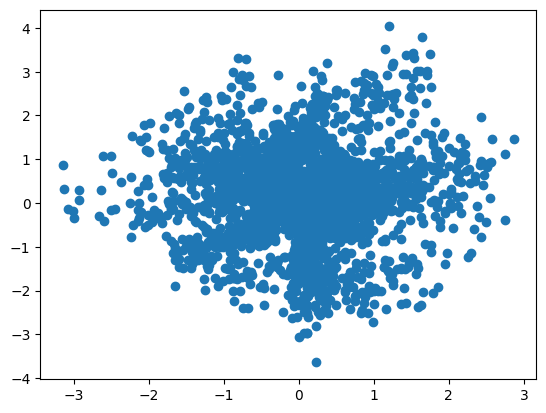

In [ ]:
h = encoder.predict(x_test[:3000], batch_size=batch_size)
plt.scatter(h[:, 0], h[:, 1])
plt.show()

<div class="alert alert-block alert-info" style="font-size:20px; background-color: #cebaff
; font-family:verdana; color: #5f4e8a; border: 2px #5f4e8a solid">
    <b>Results</b>
</div>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


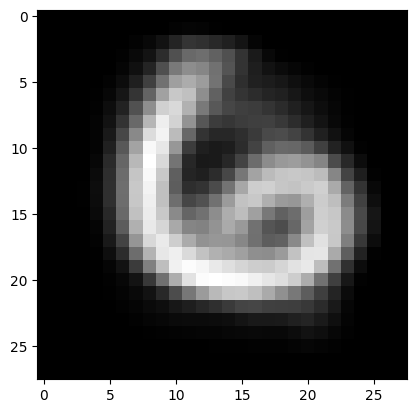

In [ ]:
image = decoder.predict(np.expand_dims([0.94, 2], axis=0))
plt.imshow(image.squeeze(), cmap="gray")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

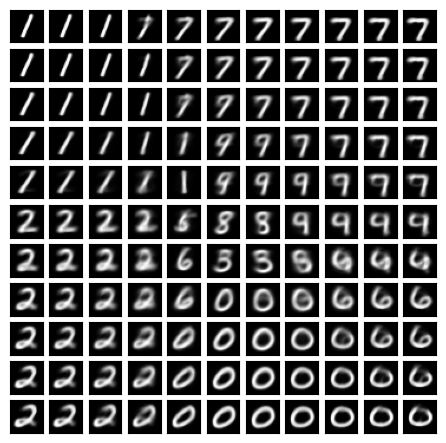

In [ ]:
n =  5
size = 2*n+1

num = 1
plt.figure(figsize=(size/2, size/2))
for i in range(-n, n+1):
    for j in range(-n, n+1):
        ax = plt.subplot(size, size, num)
        num += 1
        image = decoder.predict(np.expand_dims([3*i/n, 3*j/n], axis=0))
        plt.imshow(image.squeeze(), cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

**Exercice**: Extend this encoder to Convolutional VAE!


In [ ]:
# We create the encoder
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
x_train = x_train + ((np.random.random(x_train.shape)) / 4)
x_test = x_test + ((np.random.random(x_test.shape)) / 4)

In [ ]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


(1, 3, 3, 64)

In [ ]:
# We create the decoder
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
# Building up the full autoencoder
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 97s 50ms/step - loss: 0.4269 - val_loss: 0.3062
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 126s 42ms/step - loss: 0.3043 - val_loss: 0.2801
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - loss: 0.2825 - val_loss: 0.2695
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - loss: 0.2733 - val_loss: 0.2628
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 41ms/step - loss: 0.2654 - val_loss: 0.2498
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - loss: 0.2537 - val_loss: 0.2433
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 84s 42ms/step - loss: 0.2484 - val_loss: 0.2422
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 41ms/step - loss: 0.2462 - val_loss: 0.2384
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - loss: 0.2443 - val_loss: 0.2360
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 77s 41ms/step - loss: 0.2425 - val_loss: 0.2345


In [ ]:
def plot_perf(history):
  # Tracer les courbes de performance
  # Tracer la courbe de la perte (loss)
  plt.figure(figsize=(12, 6))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Perte d\'entraînement')
  plt.plot(history.history['val_loss'], label='Perte de validation')
  plt.title('Courbe de la Perte')
  plt.xlabel('Épochs')
  plt.ylabel('Perte')
  plt.legend()

  plt.tight_layout()
  plt.show()

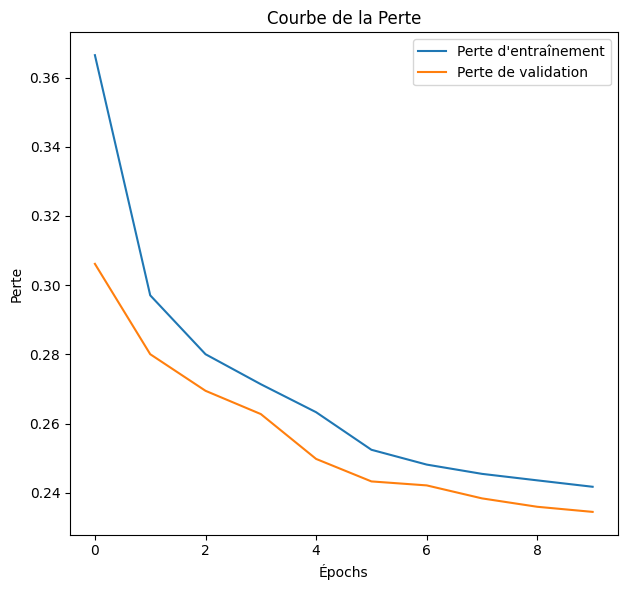

In [ ]:
plot_perf(history)